bi + ml --> final

In [1]:
import sys
sys.path.append('../../../')

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from modules import machine_learning_utils as mlu

pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

# 1.0 Data retrieval

In [3]:
df = pd.read_pickle("../../../data_lake/output/train_eng.pkl")
val = pd.read_pickle("../../../data_lake/output/val_eng.pkl")

In [4]:
cols = ['card1', 'card2', 'card3','card5','M4', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25',
       'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_32', 'id_33', 'id_34',
       'id_35', 'id_36', 'id_37', 'id_38','num_transaction_per_time']

In [5]:
df = df.drop(columns=cols)

In [6]:
val = val.drop(columns=cols)

# 2.0 Machine Learning
## 2.1 Training model

In [7]:
for i in df:
    if df[i].dtypes == 'object':
        df[i] = df[i].astype(str)

In [8]:
X_train = df.drop(columns='isFraud')
y_train = df['isFraud'].astype(float)

In [9]:
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'bool']).columns

In [10]:
parameters = {'model__max_depth':[6,8],'model__n_estimators':[500,800],'model__learning_rate':[0.05,0.1],'model__min_samples_leaf':[3,5]}

In [12]:
model = mlu.model_training(X_train,y_train,numerical_cols,categorical_cols,parameters,'no')

GridSearchCV results...
Mean Train Scores: 
[0.87915758 0.89078492 0.8819401  0.90386593 0.92404796 0.92849121
 0.91881546 0.92288487 0.9127528  0.9127528  0.90262    0.90262
 0.94310833 0.94310833 0.92666503 0.92666503]

Mean CV Scores: 
[0.8275819  0.83032306 0.82558813 0.83480718 0.8340601  0.83480755
 0.83405985 0.8338106  0.83505655 0.83505655 0.83244046 0.83244046
 0.84128581 0.84128581 0.83667489 0.83667489]

Best Parameters: 
{'model__learning_rate': 0.1, 'model__max_depth': 8, 'model__min_samples_leaf': 3, 'model__n_estimators': 500}



## 2.2 Evaluation model

In [13]:
for i in val:
    if val[i].dtypes == 'object':
        val[i] = val[i].astype(str)

In [14]:
X_val = val.drop(columns='isFraud')
y_val = val['isFraud'].astype(float)

In [15]:
m = mlu.model_calibration(model,X_val,y_val)

Test results...
Model Test Recall: 0.8517179023508138
--------------------------------------------------
Model Test Confusion Matrix
Classification report : 
               precision    recall  f1-score   support

         0.0       0.99      0.85      0.91     19976
         1.0       0.32      0.85      0.47      1659

    accuracy                           0.85     21635
   macro avg       0.65      0.85      0.69     21635
weighted avg       0.93      0.85      0.88     21635

ProductCD: 0.3204076362998419
TransactionAmt: 0.14343000107184956
card4: 0.13104672782140595
P_emaildomain: 0.025223769402368465
addr2: 0.012033488338027181
multi_transaction_per_time: 0.006267940261555033
R_emaildomain: 0.0051341140250081435
device_info_v4: 0.00510613494903186
DeviceType: 0.003658257210281853
max_d: 0.002309863815483917
max_c: 0.0014520695771733966
card6: 0.0010054128432358431
addr1: 3.549110105942713e-05
browser_enc: 2.5990696714438614e-05


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_preprocessor',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer(add_indicator=True,
                                                                                    estimator=ExtraTreesRegressor(n_estimators=5,
                                                                                                                  random_state=1),
                                                                                    random_state=1)),
                                                                  ('scaler',
                                                                   FunctionTransformer(func=<function log_transform at 0x7feb1b8d4430>))]),
                                                  Index(['TransactionAmt', 'max_c', 'max_d',...
                                 

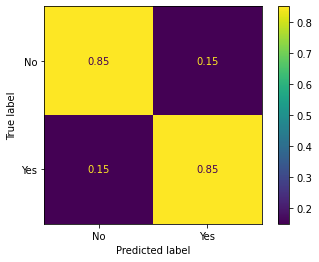

In [16]:
mlu.model_evaluation(m.base_estimator, X_val, y_val)

# 2.3 Predict probability

In [17]:
val.insert(0,'probability_score','')
val['probability_score'] = model.predict_proba(X_val)[:,1]

# 3.0 Human Knowledge

## 3.1 Traininig HK

In [18]:
df, scaler = mlu.log_beta_scaling(df,'max_c','max_d')

## 3.2 Score HK

In [19]:
val = mlu.log_beta_transform(val,scaler,'max_c','max_d')

In [20]:
val = mlu.warning_score_dev(val)

# 4.0 Error analysis

In [21]:
val.sample(2)

,probability_score,isFraud,TransactionAmt,ProductCD,card4,card6,addr1,addr2,P_emaildomain,R_emaildomain,DeviceType,max_c,max_d,multi_transaction_per_time,browser_enc,device_info_v4,warning_score
67657,0.028822,0,50.000,R,mastercard,credit,472.0,87.0,yahoo.com,anonymous.com,mobile,1.0,0.0,0,safari,ios,0.307262
103272,0.350904,0,43.382,C,visa,credit,nan,nan,gmail.com,gmail.com,mobile,4.0,527.0,0,chrome,samsung,0.871043


<AxesSubplot:>

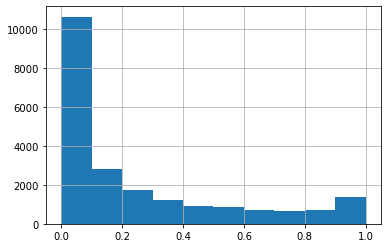

In [22]:
val['probability_score'].hist()

<AxesSubplot:>

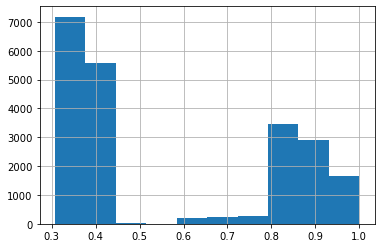

In [23]:
val['warning_score'].hist()

# 5.0 Bayesian Fusion

In [24]:
val['final_score'] = val.apply(lambda x: mlu.beta_fusion(x['probability_score'],x['warning_score'],0.6),axis=1)

In [25]:
val.sample(2)

,probability_score,isFraud,TransactionAmt,ProductCD,card4,card6,addr1,addr2,P_emaildomain,R_emaildomain,DeviceType,max_c,max_d,multi_transaction_per_time,browser_enc,device_info_v4,warning_score,final_score
64046,0.116233,0,11.722,C,visa,debit,nan,nan,hotmail.com,hotmail.com,desktop,1.0,76.833336,0,chrome,windows,0.401480,0.257298
6402,0.067494,0,149.842,C,visa,debit,465.0,60.0,hotmail.com,hotmail.com,desktop,2.0,311.000000,0,safari,other,0.891109,0.407246


<AxesSubplot:>

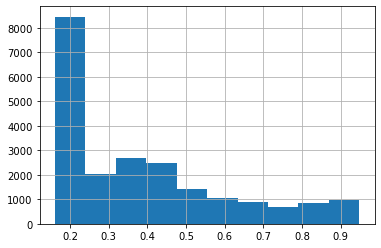

In [26]:
val['final_score'].hist()

# 6.0 Model Output

In [27]:
with open('../../../data_lake/output/trained_model_v1.pkl','wb') as file:
    pickle.dump(m.base_estimator, file)

In [28]:
with open('../../../data_lake/output/log_scaler_bi.pkl','wb') as file:
    pickle.dump(scaler, file)